In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [4]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [165]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(10)

1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


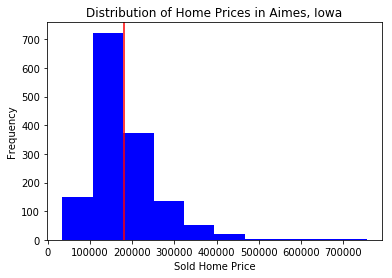

Mean house price in Aimes:  180921.19589041095


In [170]:
#Since we are estimating the saleprice I want to check the distribution
plt.hist(house_prices_df['saleprice'], color ='b')
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r', alpha=1.0)
plt.title('Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean house price in Aimes: ', house_prices_df['saleprice'].mean())

The sale price of the homes in Aimes, Iowa seems to be right-skewed with a few homes selling in the $ 700,000 range and the mean price at $ 180,000. Next, I want to dig into some of the variables and determine whether or not they would be a good fit for the model. Most of the data is categorical with string values for different classifiers, so the following evaluation will include digging into most of them one by one.

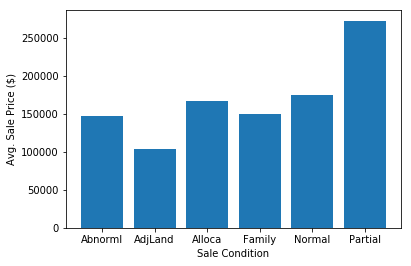

In [196]:
#print(house_prices_df.salecondition.value_counts())
plt.bar(
    house_prices_df.groupby('salecondition')['saleprice'].mean().index,
    house_prices_df.groupby('salecondition')['saleprice'].mean()
)
plt.xlabel('Sale Condition')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

The sale condition of the home represents the condition of the house. The partial case that has a higher average home sale price is representative of homes that are only partially finished(i.e. new builds). Classifying whether a home is in this class could help predict the sale price, especially given the disparity in the average sale price when compared to normal sale conditions.

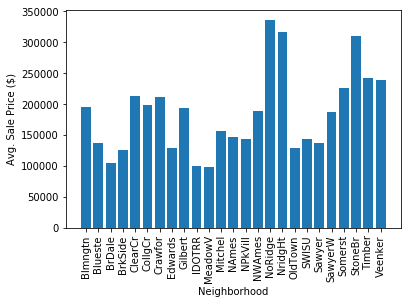

In [195]:
plt.bar(
    house_prices_df.groupby('neighborhood')['saleprice'].mean().index,
    house_prices_df.groupby('neighborhood')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

#house_prices_df.neighborhood.value_counts()

There are a lot of neighborhoods in the dataset which could diminish the effectiveness of this feature. The neighborhoods with the high average sale prices make up less than 10% of the dataset and are likely not representative of average home prices in the area.

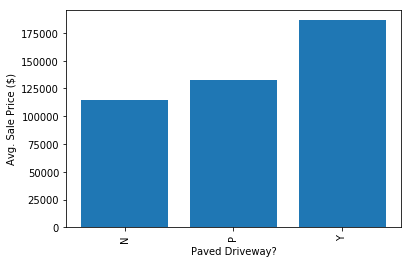

In [176]:
plt.bar(
    house_prices_df.groupby('paveddrive')['saleprice'].mean().index,
    house_prices_df.groupby('paveddrive')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Paved Driveway?')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

Interestingly whether or not the driveway is paved has a clear impact on the average home price. This could be an interesting feature to use in the regression model.

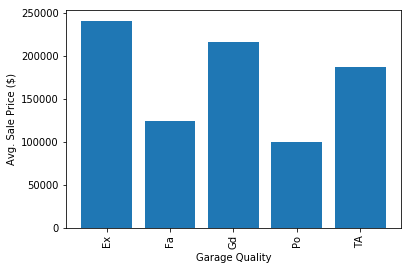

In [175]:
plt.bar(
    house_prices_df.groupby('garagequal')['saleprice'].mean().index,
    house_prices_df.groupby('garagequal')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Garage Quality')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

The good and excellent quality garages do demand a higher price than the fair and poor quality ones, but it is not that much more than the totally average ones. I think I will leave this one out of the analysis.

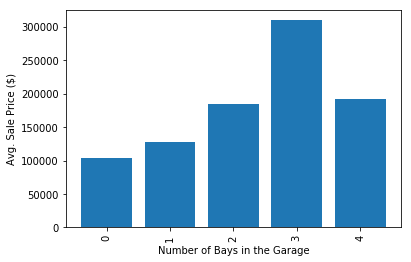

In [194]:
#print(house_prices_df.garagecars.value_counts())
plt.bar(
    house_prices_df.groupby('garagecars')['saleprice'].mean().index,
    house_prices_df.groupby('garagecars')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Number of Bays in the Garage')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

There is a big jump from the low $ 200,000 range to over $ 300,000 average price when the house has a 3 car garage. Whether or not the house has a 3 car garage will be a good binary feature to create and use in the model.

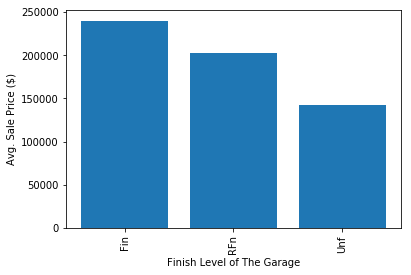

In [193]:
#print(house_prices_df.garagefinish.value_counts())
plt.bar(
    house_prices_df.groupby('garagefinish')['saleprice'].mean().index,
    house_prices_df.groupby('garagefinish')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Finish Level of The Garage')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

There is an increasing trend in home prices when compared to whether or not the garage is finished out or not. Categorizing the homes with finished garages could help the model. The feature engineering will be done in one chunk of code at the end of the data exploration sections.

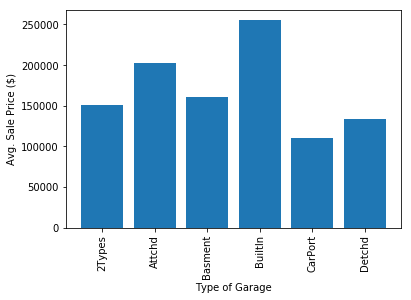

In [192]:
#print(house_prices_df.garagetype.value_counts())
plt.bar(
    house_prices_df.groupby('garagetype')['saleprice'].mean().index,
    house_prices_df.groupby('garagetype')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Type of Garage')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

Homes with attached garages have a higher average sale price than homes with detached garages, and builtin garages with rooms above them are a type of attached garage. I want to try and run a model that includes each of these features, but would want to classify the homes with attached and builtin categories as one feature "attached garages".

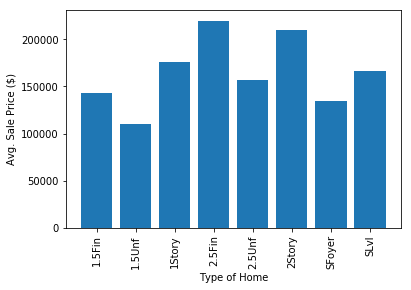

In [191]:
#print(house_prices_df.housestyle.value_counts())
plt.bar(
    house_prices_df.groupby('housestyle')['saleprice'].mean().index,
    house_prices_df.groupby('housestyle')['saleprice'].mean()
)
plt.xticks(rotation=90)
plt.xlabel('Type of Home')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

There are lots of different types of homes in the dataset, but they have direct correlations with one another. If the home is 2 story (then it definitely isn't a one story) it could be either unfinished or finished which have different effects on the price and would provide unpredictable results.

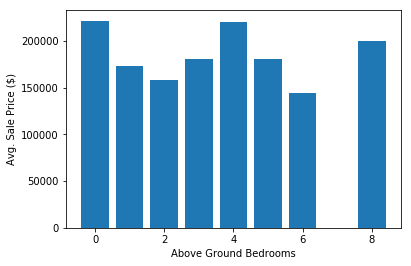

In [199]:
plt.bar(
    house_prices_df.groupby('bedroomabvgr')['saleprice'].mean().index,
    house_prices_df.groupby('bedroomabvgr')['saleprice'].mean()
)
plt.xlabel('Above Ground Bedrooms')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

Typically one would think that the number of bedrooms would be loosely correlated to the size of the home and the price, but in this case it looks like that assumption does not hold true.

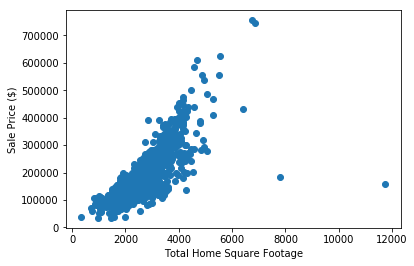

In [202]:
#summing the measured square footage for the floors in all homes
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

plt.scatter(
    house_prices_df['total_sf'],
    house_prices_df['saleprice']
)
plt.xlabel('Total Home Square Footage')
plt.ylabel('Sale Price ($)')
plt.show()

There is a strong correlation between the square footage of the home and the sale price. This will be an important feature to include in the models.

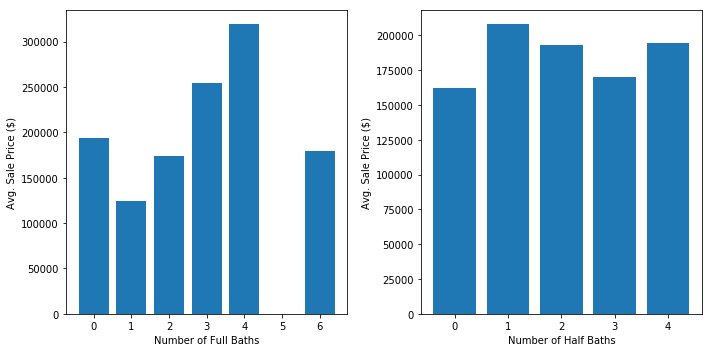

In [208]:
#Generating Bathroom counts for all the houses
house_prices_df['total_full_baths'] = house_prices_df['bsmtfullbath'] + house_prices_df['fullbath']
house_prices_df['total_half_baths'] = house_prices_df['bsmthalfbath'] + house_prices_df['halfbath']

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(
    house_prices_df.groupby('total_full_baths')['saleprice'].mean().index,
    house_prices_df.groupby('total_full_baths')['saleprice'].mean()
)
plt.xlabel('Number of Full Baths')
plt.ylabel('Avg. Sale Price ($)')

plt.subplot(1,2,2)
plt.bar(
    house_prices_df.groupby('total_half_baths')['saleprice'].mean().index,
    house_prices_df.groupby('total_half_baths')['saleprice'].mean()
)
plt.xlabel('Number of Half Baths')
plt.ylabel('Avg. Sale Price ($)')

plt.tight_layout()
plt.show()

There does seem to be a peak in price for homes with 4 full baths, but the correlation with the number of baths and sale price is pretty poor. It's a similar story for the half baths, the average sale prices for all classes are fairly similar. I think I will leave these features out of the model.

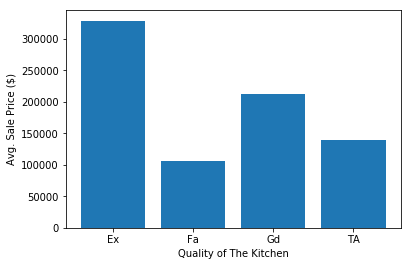

In [209]:
plt.bar(
    house_prices_df.groupby('kitchenqual')['saleprice'].mean().index,
    house_prices_df.groupby('kitchenqual')['saleprice'].mean()
)
plt.xlabel('Quality of The Kitchen')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

#house_prices_df.kitchenqual.value_counts()

There is an interesting correlation with these features. The kitchens that are above average (Excellent & Good) have significantly higher average sale prices than those homes with average of fair quality kitchens. I will create a feature below that will take the kitchen quality into account for the model.

### Feature Engineering

For the next bit of the project I want to create numeric features for all of the categorical features that I talked about above. The next chunk of the project will be devoted to creating the features, checking that they are in the dataframe correctly and then moving onto the modeling.

In [143]:
garage_type = pd.get_dummies(house_prices_df['garagetype'], prefix='garagetype')
house_prices_df = pd.concat([house_prices_df, garage_type], axis=1)

In [144]:
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)

In [102]:
paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

In [181]:
garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

In [182]:
house_prices_df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities',
       ...
       'garagetype_CarPort', 'garagetype_Detchd', 'car_garage_0',
       'car_garage_1', 'car_garage_2', 'car_garage_3', 'car_garage_4',
       'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf'],
      dtype='object', length=102)

In [140]:
#Does the house have an above average kitchen feature
house_prices_df['awesome_kitchen'] = 9999

In [142]:
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

0    774
1    686
Name: awesome_kitchen, dtype: int64

In [187]:
#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

1    958
0    502
Name: attached_garage, dtype: int64

### Linear Regression Modeling and Iterations

In [210]:
Y = house_prices_df['saleprice']
X = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_N', 
                    'paved_driveway_P', 
                    'paved_driveway_Y',
                    'garagetype_2Types', 
                    'garagetype_Attchd',
                    'garagetype_Basment', 
                    'garagetype_BuiltIn', 
                    'garagetype_CarPort',
                    'garagetype_Detchd', 
                    'car_garage_0', 
                    'car_garage_1', 
                    'car_garage_2',
                    'car_garage_3', 
                    'car_garage_4',
                    'garagefinish_Fin'
                    ]
                   ]
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     325.6
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:00:30   Log-Likelihood:                -17504.
No. Observations:                1460   AIC:                         3.504e+04
Df Residuals:                    1445   BIC:                         3.512e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.859e+04   3854.620      4.822      0.000     1.1e+04    2.61e+04
awesome_kitchen     2.759e+04   2484.393     11.104      0.000    2.27e+04    3.25e+04
total_sf              46.6601      1.612     28.947      0.000      43.498      49.822
paved_driveway_N     522.4720   3843.567      0.136      0.892   -7017.096    8062.040
paved_driveway_P    6265.6597   5594.775      1.120      0.263   -4709.091    1.72e+04
paved_driveway_Y     1.18e+04   2754.733      4.282      0.000    6393.250    1.72e+04
garagetype_2Types  -5.827e+04   1.42e+04     -4.102      0.000   -8.61e+04   -3.04e+04
garagetype_Attchd   2.403e+04   3797.058      6.328      0.000    1.66e+04    3.15e+04
garagetype_Basment  2.141e+04   8451.729      2.533      0.011    4831.736     3.8e+04
garagetype_BuiltIn  3.623e+04   5267.272      6.879      0.000    2.59e+04    4.66e+04
garagetype_CarPort -2212.2017   1.17e+04     -0.190      0.850   -2.51e+04    2.07e+04
garagetype_Detchd   1.189e+04   3868.185      3.073      0.002    4299.572    1.95e+04
car_garage_0       -1.449e+04   4707.821     -3.078      0.002   -2.37e+04   -5253.684
car_garage_1       -2.185e+04   4160.747     -5.251      0.000      -3e+04   -1.37e+04
car_garage_2       -9092.3202   3933.312     -2.312      0.021   -1.68e+04   -1376.708
car_garage_3        5.218e+04   4795.410     10.880      0.000    4.28e+04    6.16e+04
car_garage_4        1.184e+04   1.45e+04      0.815      0.415   -1.66e+04    4.03e+04
garagefinish_Fin    1.608e+04   2708.337      5.938      0.000    1.08e+04    2.14e+04
==============================================================================
Omnibus:                      467.947   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41279.211
Skew:                          -0.501   Prob(JB):                         0.00
Kurtosis:                      29.030   Cond. No.                     3.99e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.65e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### First Iteration Results

First model just included all of the features that were engineered or had a strong relationship with the sales price of the home, without first checking for multicollinearity. I will make a heatmap below to remove some of the more highly correlated features and then re-run the model.

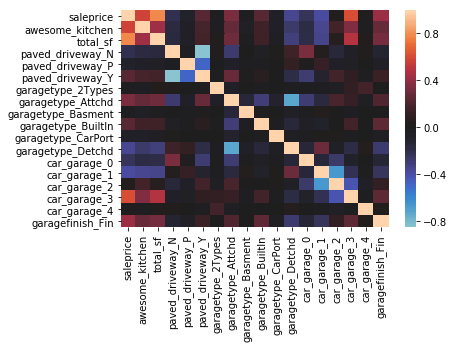

In [212]:
features = house_prices_df[[
                    'saleprice', 
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_N', 
                    'paved_driveway_P', 
                    'paved_driveway_Y',
                    'garagetype_2Types', 
                    'garagetype_Attchd',
                    'garagetype_Basment', 
                    'garagetype_BuiltIn', 
                    'garagetype_CarPort',
                    'garagetype_Detchd', 
                    'car_garage_0', 
                    'car_garage_1', 
                    'car_garage_2',
                    'car_garage_3', 
                    'car_garage_4', 
                    'garagefinish_Fin'
                    ]
                   ]

sns.heatmap(features.corr(), center=0)
plt.show()

Multiple features are inherently correlated with one another because of the classification system. For example, if we have an attached garage then there is a good chance that we don't have a detached garage. I'll remove the features below that are highly correlated with one another and rerun the model.

In [213]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'garagetype_2Types', 
                    'garagetype_Attchd',
                    'garagetype_Basment', 
                    'garagetype_BuiltIn', 
                    'garagetype_CarPort', 
                    'car_garage_3', 
                    'garagefinish_Fin'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     445.4
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:03:03   Log-Likelihood:                -17519.
No. Observations:                1460   AIC:                         3.506e+04
Df Residuals:                    1449   BIC:                         3.512e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8783.7377   4802.160      1.829      0.068    -636.191    1.82e+04
awesome_kitchen     3.052e+04   2429.183     12.563      0.000    2.58e+04    3.53e+04
total_sf              48.3906      1.590     30.429      0.000      45.271      51.510
paved_driveway_Y    1.296e+04   4000.577      3.239      0.001    5110.820    2.08e+04
garagetype_2Types   -6.05e+04   1.64e+04     -3.691      0.000   -9.27e+04   -2.84e+04
garagetype_Attchd   1.426e+04   2660.103      5.362      0.000    9046.738    1.95e+04
garagetype_Basment  1.047e+04   9294.422      1.127      0.260   -7757.068    2.87e+04
garagetype_BuiltIn  2.605e+04   5114.664      5.093      0.000     1.6e+04    3.61e+04
garagetype_CarPort  -1.03e+04   1.33e+04     -0.774      0.439   -3.64e+04    1.58e+04
car_garage_3        6.075e+04   3699.483     16.422      0.000    5.35e+04     6.8e+04
garagefinish_Fin    1.766e+04   2711.199      6.513      0.000    1.23e+04     2.3e+04
==============================================================================
Omnibus:                      511.805   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43959.324
Skew:                          -0.681   Prob(JB):                         0.00
Kurtosis:                      29.847   Cond. No.                     4.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Second Iteration Results
Removing the features that correlated highly with one another had very little effect on the R-squared value for the model. The condition number is coming down from the first model (e+19 to e+04), other than that they seem to be pretty similar. The coefficients for each of the features have only changed slightly from the first model.

For the third iteration, I want to use the feature I created earlier for attached garages and remove the other features that are related to the type of garage the house has.

In [189]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'car_garage_3', 
                    'garagefinish_Fin'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     729.2
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:37:33   Log-Likelihood:                -17530.
No. Observations:                1460   AIC:                         3.507e+04
Df Residuals:                    1453   BIC:                         3.511e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8091.6793   4829.049      1.676      0.094   -1380.973    1.76e+04
awesome_kitchen   3.128e+04   2436.568     12.837      0.000    2.65e+04    3.61e+04
total_sf            48.3731      1.597     30.292      0.000      45.241      51.506
paved_driveway_Y    1.3e+04   4014.623      3.237      0.001    5121.733    2.09e+04
attached_garage   1.529e+04   2606.522      5.867      0.000    1.02e+04    2.04e+04
car_garage_3      5.968e+04   3687.203     16.186      0.000    5.24e+04    6.69e+04
garagefinish_Fin  1.906e+04   2682.853      7.105      0.000    1.38e+04    2.43e+04
==============================================================================
Omnibus:                      494.712   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41343.874
Skew:                          -0.627   Prob(JB):                         0.00
Kurtosis:                      29.039   Cond. No.                     1.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Final Iteration Results

For the last iteration of the model (for now), most everything is the same as the last model. The R-squared has remained at a 0.75 and the condition number is still coming down (4e+04 to 1.5e+04). When looking at the last heatmap that I made there are still some correlations between the features that are still remaining in the model, but they are weaker than the original feature set.

An interesting observation here is that I was able to build a model that did an ok job of predicting a home sale price based off the size of the home, how nice the kitchen was, and details about the quality/size of the garage. This could be a larger indicator for what residents in the Aimes, Iowa area are looking for in a home. It would be interesting to expand this dataset to a region of the United States and include demographic data about the purchasers of each home. 